# Placa 2D Elastoestática

Notebook feito com base em:  
* **Artigo:** Haghighat etal (2021) - *A physics-informed deep learning framework for inversion and surrogate modeling in solid mechanics*. DOI: [https://doi.org/10.1016/j.cma.2021.113741](https://doi.org/10.1016/j.cma.2021.113741)
* **Exemplo DeepXDE:** [Linear elastostatic equation over a 2D square domain](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/elasticity.plate.html)

**Notebook por:** Paulo de Souza Silva  
**Data:** Maio/Junho de 2025

**IGNORE ESTE CÓDIGO INICIAL**

* Se a figura da viga não aparecer, basta rodá-lo.

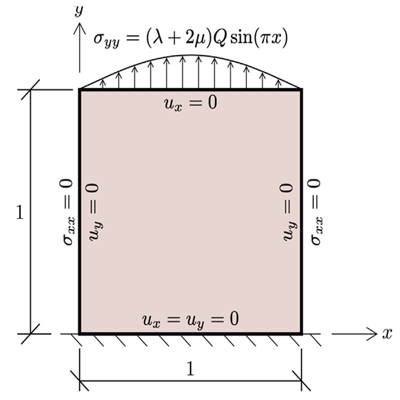

In [4]:
import requests
from PIL import Image
from io import BytesIO

file_id = '14u5cooicty9DaIazuSlEd6JJSy0OSkG-'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (400, 400)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)

A placa 2D definida na figura é caracterizada como um cenário de um problema de Elasticidade Linear, em que o formalismo com simbolismo tensorial é dado por:

$$\begin{aligned}
\sigma_{ij,j} + f_i & = 0 \\
\sigma_{ij} & = \lambda \delta_{ij} \varepsilon_{kk} + 2\mu \varepsilon_{ij} \\
\varepsilon_{ij} & = \frac{1}{2} (u_{i,j} + u_{j,i})
\end{aligned}$$

Ao abrir essas equações temos para a **primeira equação**:
$$\frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xy}}{\partial y} + f_x= 0, \quad
\frac{\partial \sigma_{xy}}{\partial x} + \frac{\partial \sigma_{yy}}{\partial y} + f_y= 0,$$

para a **segunda:**
$$\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda\epsilon_{yy}, \quad
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda\epsilon_{xx}, \quad
\sigma_{xy} =  2\mu\epsilon_{xy},$$

para a **última**
$$\epsilon_{xx} = \frac{\partial u_{x}}{\partial x}, \quad
\epsilon_{yy} = \frac{\partial u_{y}}{\partial y}, \quad
\epsilon_{xy} = \frac{1}{2}(\frac{\partial u_{x}}{\partial y} + \frac{\partial u_{y}}{\partial x}).$$




Nesse contexto, o domínio é definido por:
$$x \in [0, 1], \quad y \in [0, 1]$$

As forças de corpo são:
$$
\begin{split}f_x & = \lambda[4\pi^2\cos(2\pi x)\sin(\pi y) - \pi\cos(\pi x)Qy^3] \\
    & + \mu[9\pi^2\cos(2\pi x)\sin(\pi y) - \pi\cos(\pi x)Qy^3], \\
f_y & = \lambda[-3\sin(\pi x)Qy^2 + 2\pi^2\sin(2\pi x)\cos(\pi y)] \\
    & + \mu[-6 \sin(\pi x)Qy^2 + 2 \pi^2\sin(2\pi x)\cos(\pi y) + \pi^2\sin(\pi x)Qy^4/4],\end{split}
$$

As definições para os deslocamentos no contorno são:
$$u_x(x, 0) = u_x(x, 1) = 0,\\ u_y(0, y) = u_y(1, y) = u_y(x, 0) = 0,$$

e as condições de *traction*
$$\sigma_{xx}(0, y)=0, \quad \sigma_{xx}(1, y)=0, \quad \sigma_{yy}(x, 1)=(\lambda + 2\mu)Q\sin(\pi x)$$

Os parâmetros ainda são definidos: $\lambda = 1, \mu = 0.5,$ e $Q = 4$.

Sendo a solução exata do problema:
$$u_x(x, y) = \cos(2\pi x)\sin(\pi y) \\ u_y(x, y) = \sin(\pi x)Qy^4/4$$



## Começo do Código

**instalando o DeepXDE**

In [5]:
! pip install -q deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.4 MB/s eta 0:00:00


**bibliotecas importantes**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch
dde.backend.backend_name = "pytorch"

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


**definição de funções**

In [7]:
# Define functions
sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack

**definição dos parametros**

In [8]:
lmbd = 1.0
mu = 0.5
Q = 4.0

**definição da solução exata**

DESLOCAMENTOS
$$u_x(x, y) = \cos(2\pi x)\sin(\pi y) \\ u_y(x, y) = \sin(\pi x)Qy^4/4$$

DEFORMAÇÕES
$$\begin{aligned}
\epsilon_{xx} &= - 2 \pi \sin{\left(2 \pi x \right)} \sin{\left(\pi y \right)}\\
\epsilon_{yy} &= Q y^{3} \sin{\left(\pi x \right)} \\
\epsilon_{xy} &= \frac{1}{2} \left(\frac{\pi Q y^{4} \cos{\left(\pi x \right)}}{4} + \pi \cos{\left(2 \pi x \right)} \cos{\pi y }\right)
\end{aligned}
$$

TENSÕES
$$\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda\epsilon_{yy}, \quad
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda\epsilon_{xx}, \quad
\sigma_{xy} =  2\mu\epsilon_{xy}$$

In [9]:
# Exact solutions
def func(x):
    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4)

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))

**TOME NOTA:** Perceba que a solução analítica retorna **5 valores** (dois deslocamentos e três tensões), dessa forma, a nossa rede será construída para fazer a mesma coisa.

### Condição de Contorno

**definição da geometria**  
Como estamos trabalhando com um retângulo bem definido, é possível usar o comando **`geometry.Rectangle`**

In [10]:
geom = dde.geometry.Rectangle([0, 0], [1, 1])

**definir se a condição será do tipo *hard* ou *soft***

In [33]:
BC_type = ["hard", "soft"][1]  # Escolher [0] - hard ou [1] - soft

Assim como no caso 1D, temos que definir onde é o contorno dentro da geometria definida, usando a questão de um comparativo **booleano**, como estamos em um quadrado, é necessário definir:

* **Contorno da Esquerda**
* **Contorno da Direita**
* **Contorno de Topo**
* **Contorno Inferior**

Note que é necessário definir `x[0]` e `x[1]` que se referem as posições $x$ e $y$ respectivamente.

In [34]:
def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)


def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


**Condições no caso Soft**

Para o caso soft, podem ser definidas condições de Dirichlet (associada somente as funções), para $u_x, u_y, \sigma_{xx}$ e $\sigma_{yy}$, como definido na teoria:

As definições para os deslocamentos no contorno são:
$$u_x(x, 0) = u_x(x, 1) = 0,\\ u_y(0, y) = u_y(1, y) = u_y(x, 0) = 0,$$

e as condições de *traction*
$$\sigma_{xx}(0, y)=0, \quad \sigma_{xx}(1, y)=0, \quad \sigma_{yy}(x, 1)=(\lambda + 2\mu)Q\sin(\pi x)$$

**Obs** A saída da rede vai seguir o formato $[u_x, u_y, \sigma_{xx}, \sigma_{yy},\sigma_{xy}]$ então o deslocamento em x é **componente 0**, a tensão y é a **compoente 3**.

In [35]:
# Soft Boundary Conditions
ux_top_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_top, component=0)
ux_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
uy_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=1)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
uy_right_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=1)
sxx_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=2)
sxx_right_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=2)
syy_top_bc = dde.icbc.DirichletBC(geom,lambda x: (2 * mu + lmbd) * Q * np.sin(np.pi * x[:, 0:1]), boundary_top, component=3)

**Condição no caso Hard**  
Para o caso Hard, em que as condições devem ser impostas na própria formulação de saída da rede, é possível definir:

* $u_x^{nn} = \hat{u}_{x}^{nn}\cdot y \cdot (1 - y)$
* $u_y^{nn} = \hat{u}_{x}^{nn}\cdot x \cdot (1 - x) \cdot y$
* $\sigma_{xx}^{nn} = \hat{\sigma}_{xx}^{nn}\cdot x \cdot (1 - x)$
* $\sigma_{yy}^{nn} = \hat{\sigma}_{yy}^{nn}\cdot (1 - y) + (\lambda + 2 \cdot \mu) \cdot Q \cdot \sin(\pi x)$
* $\sigma_{xy}^{nn} = \hat{\sigma}_{xy}^{nn}$

In [36]:
# Hard Boundary Conditions
def hard_BC(x, f):
    Ux = f[:, 0] * x[:, 1] * (1 - x[:, 1])
    Uy = f[:, 1] * x[:, 0] * (1 - x[:, 0]) * x[:, 1]

    Sxx = f[:, 2] * x[:, 0] * (1 - x[:, 0])
    Syy = f[:, 3] * (1 - x[:, 1]) + (lmbd + 2 * mu) * Q * sin(np.pi * x[:, 0])
    Sxy = f[:, 4]
    return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)

### Equações da PDE

**força de corpo $f_x$**
$$
\begin{split}f_x & = \lambda[4\pi^2\cos(2\pi x)\sin(\pi y) - \pi\cos(\pi x)Qy^3] \\
    & + \mu[9\pi^2\cos(2\pi x)\sin(\pi y) - \pi\cos(\pi x)Qy^3]
\end{split}$$

**Nota:** O notebook original troca o sinal das funções de corpo, para não ocasionar nenhum problema isso se manteve; é importante notar que na definição da PDE o sinal também está trocado, o que coincide com a teoria.

In [37]:
def fx(x):
    return (
        -lmbd* (4 * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1]))
        - mu*(np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1]))
        - 8 * mu * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
    )


**força de corpo $f_y$**  
$$
\begin{split}
f_y & = \lambda[-3\sin(\pi x)Qy^2 + 2\pi^2\sin(2\pi x)\cos(\pi y)] \\
    & + \mu[-6 \sin(\pi x)Qy^2 + 2 \pi^2\sin(2\pi x)\cos(\pi y) + \pi^2\sin(\pi x)Qy^4/4]  
\end{split}$$

In [38]:
def fy(x):
    return (
        lmbd* ( 3 * Q * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
         - 2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1]))
        - mu * (2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
            + (Q * x[:, 1:2] ** 4 * np.pi**2 * sin(np.pi * x[:, 0:1])) / 4)
        + 6 * Q * mu * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
    )

**definindo uma funcao para as derivadas**

In [39]:
def jacobian(f, x, i, j):
    if dde.backend.backend_name == "jax":
        return dde.grad.jacobian(f, x, i=i, j=j)[0]
    else:
        return dde.grad.jacobian(f, x, i=i, j=j)

**definindo as funcoes da PDE**
* Calcula-se as deformações: $\varepsilon_{xx}, \varepsilon_{yy}, \varepsilon_{xy}$
* Calcula-se as tensões: $\sigma_{xx}, \sigma_{yy}, \sigma_{xy}$
* Deriva-se as tensões: $\sigma_{xx,x}, \sigma_{yy,y}, \sigma_{xy,x}, \sigma_{xy,y}$


In [40]:
def pde(x, f):
    E_xx = jacobian(f, x, i=0, j=0)
    E_yy = jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    # Na teoria temos:
    #     sigx_x + sigxy_y + fx = 0
    #     sigy_y + sigxy_x + fy = 0
    # como o sinal de fx e fy foram trocados aqui tambem deve ser alterado
    momentum_x = Sxx_x + Sxy_y - fx(x)
    momentum_y = Sxy_x + Syy_y - fy(x)

    if dde.backend.backend_name == "jax":
        f = f[0]  # f[1] is the function used by jax to compute the gradients

    # Aqui são definicoes complementares:
    #    O valor das tensoes encontradas pela rede para as tensoes (f[2], f[3] e
    # f[4]) devem ser similares aos encontrados via calculo com os resultados de
    # f[0] e f[1]
    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

**evidenciando o tipo de contorno**

In [41]:
if BC_type == "hard":
    bcs = []
else:
    bcs = [
        ux_top_bc,
        ux_bottom_bc,
        uy_left_bc,
        uy_bottom_bc,
        uy_right_bc,
        sxx_left_bc,
        sxx_right_bc,
        syy_top_bc,
    ]


**criando os dados**

`solution` : utilizado quando se tem os dados exatos

In [42]:
data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=500,
    num_boundary=500,
    solution=func,
    num_test=100,
)

**definicao da rede, otimizador e treino do modelo**

Aqui utilizaremos, um formato de rede diferente do FNN tradicional, será usada a rede do tipo **Parallel Fully Connected Neural Network (PFNN)** (presente no framework com PyTorch)

Nesse tipo de rede, é preciso informar quantas **sub-redes** serão utilizadas, o ideal é que a quantidade seja similar ao número de valores de saída do problema.

É necessário definir o layer da seguinte maneira: vamos considerar:
* 2 entradas
* 5 sub-redes, cada uma com 40 neurônios
* 4 camadas escondidas em cada sub-rede
* 5 saídas

Então temos que escrever:
$$layer = [2, \underbrace{[40]^*5,[40]^*5,[40]^*5,[40]^*5}_\text{4 camadas escondidas por sub-rede},5]$$

Para mais informações consultar: [PFNN](https://deepxde.readthedocs.io/en/latest/modules/deepxde.nn.pytorch.html#deepxde.nn.pytorch.fnn.PFNN)

### Observações
A quantidade de valores da Loss, o tempo de otimização e a qualidade dos resultados se alteram de acordo com o tipo de Contorno definido (*hard* ou *soft*), a tabela abaixo resume para uma estrutura de rede o que pode ocorrer

| | Hard | Soft |  
|:---|:---:|:---:|  
|Qtd de Loss | 5 | 11
|Tempo (min)| 6 | 10
|Resultado | Razoável | Bom


**Estrutura:**
* Função de Ativação: Tangente Hiperbólica
* Otimizador: Adam
* Taxa de Aprendizado: 0.001
* Iterações: 5000

In [43]:
layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.PFNN(layers, activation, initializer)

if BC_type == "hard":
    net.apply_output_transform(hard_BC)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=5000)

#dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.853700 s

'compile' took 5.242585 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric   
0         [1.80e+03, 2.72e+02, 1.52e+00, 2.55e-01, 1.25e-01, 2.01e-01, 2.37e-01, 3.59e-04, 2.37e-01, 6.05e-01, 3.59e-04, 6.05e-01, 3.61e+01]    [1.77e+03, 2.66e+02, 1.45e+00, 1.78e-01, 7.29e-02, 2.01e-01, 2.37e-01, 3.59e-04, 2.37e-01, 6.05e-01, 3.59e-04, 6.05e-01, 3.61e+01]    [1.09e+00]    
1000      [2.28e-01, 1.43e-01, 7.17e-02, 9.47e-02, 3.14e-01, 1.90e-01, 3.82e-02, 5.74e-02, 9.84e-02, 3.48e-02, 4.07e-02, 2.89e-02, 3.31e-02]    [2.26e-01, 1.60e-01, 1.29e-01, 1.81e-01, 6.14e-01, 1.90e-01, 3.82e-02, 5.74e-02, 9.84e-02, 3.48e-02, 4.07e-02, 2.89e-02, 3.31e-02]    [5.84e

## Plot dos Gráficos

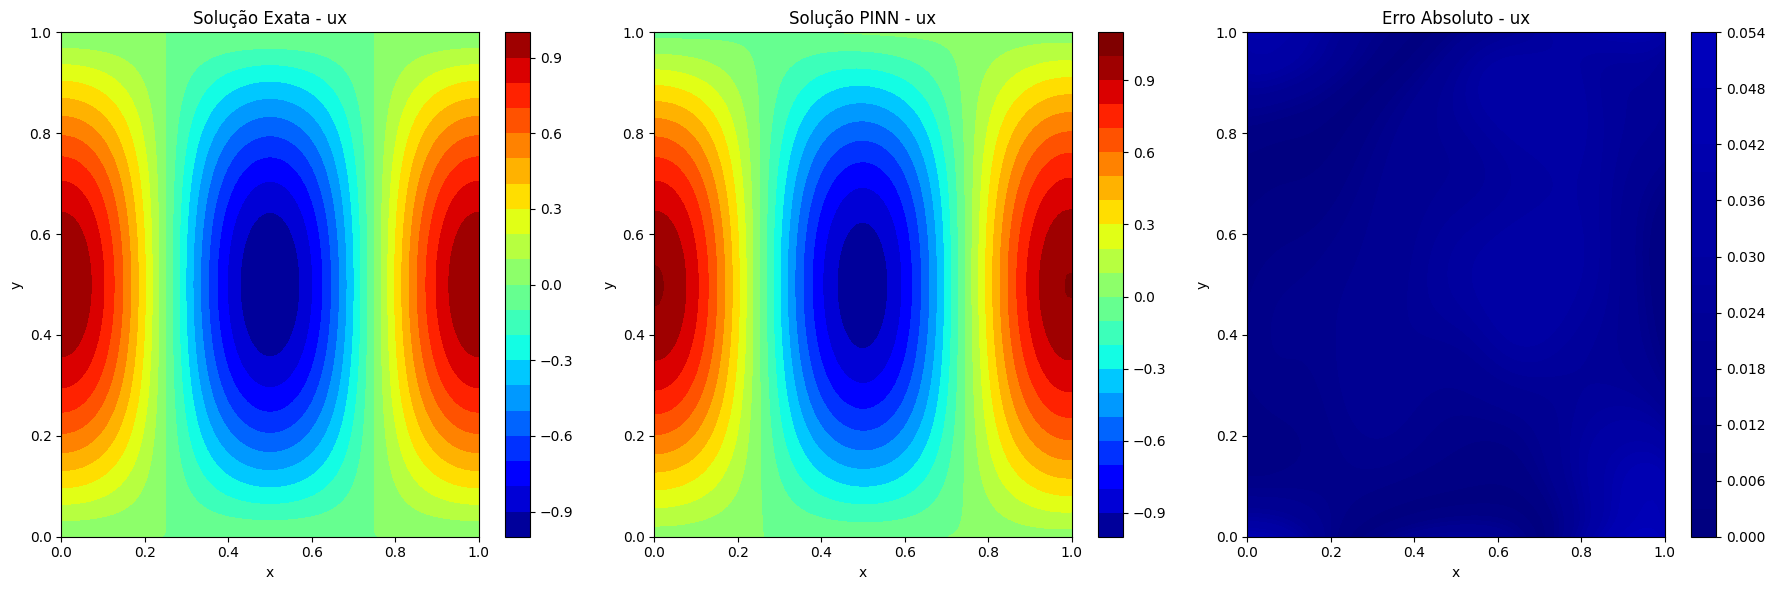

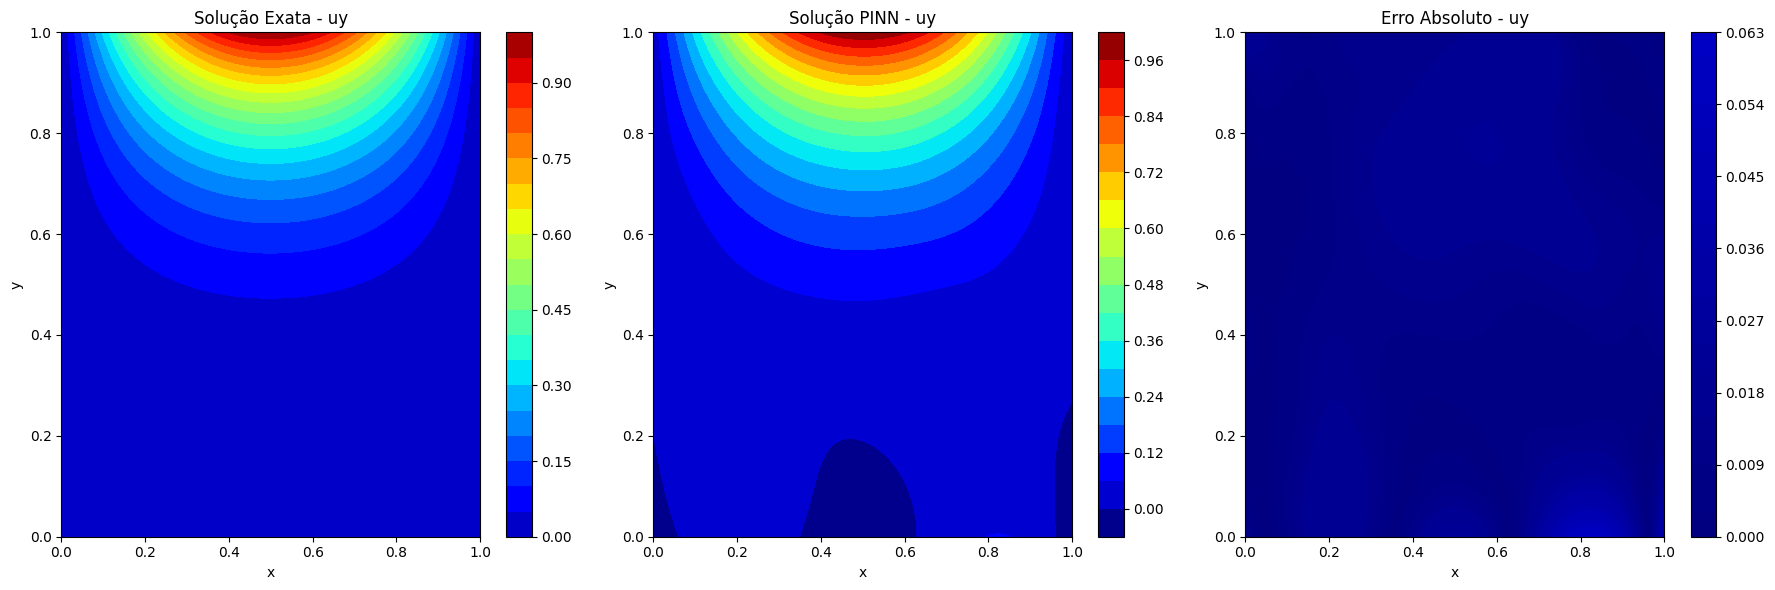

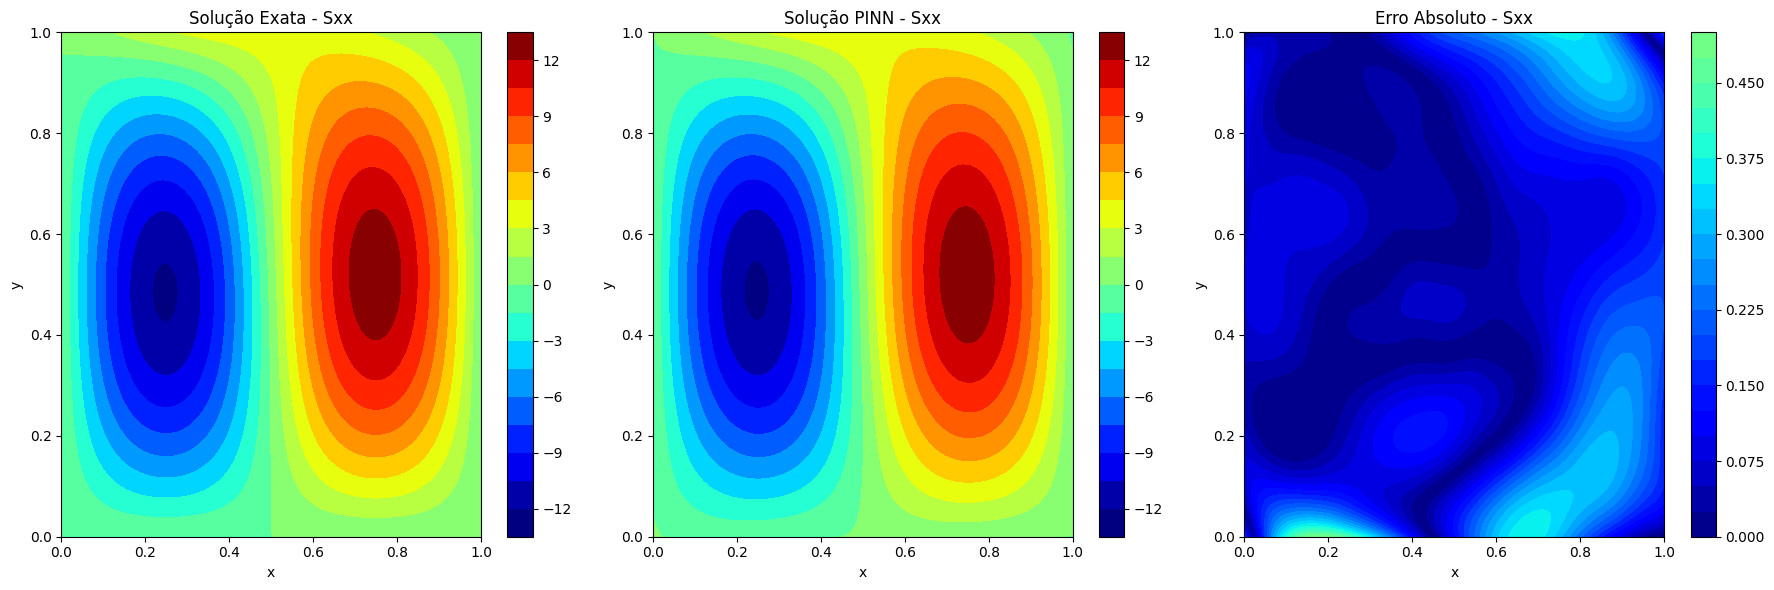

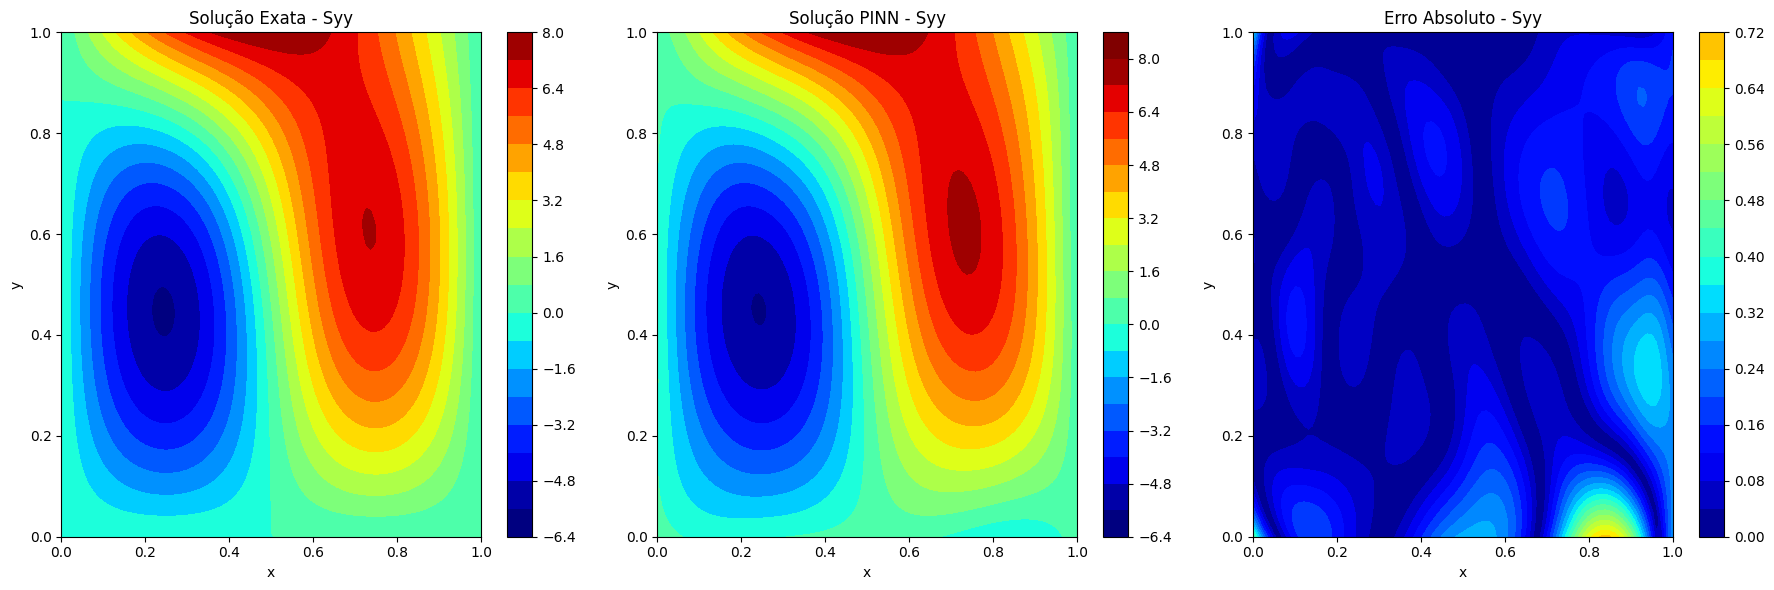

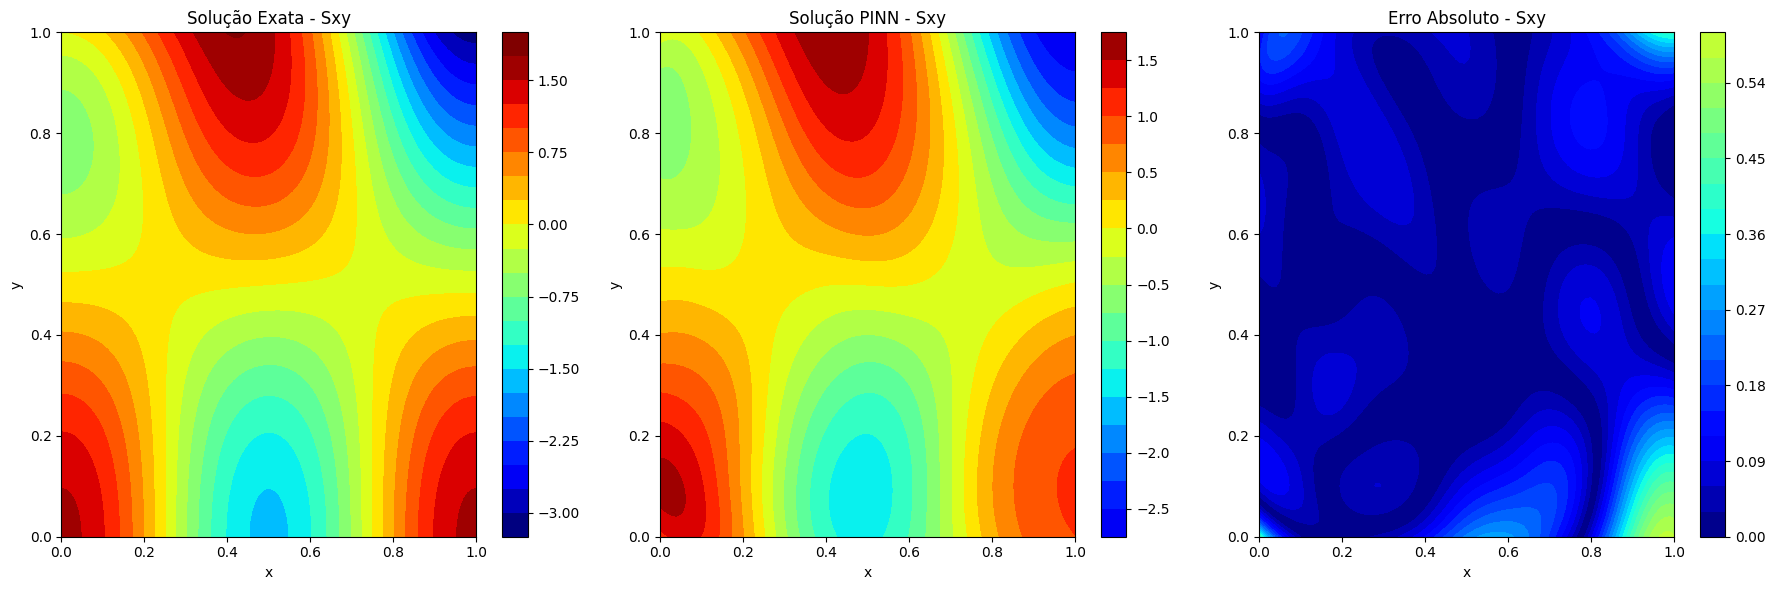

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Criar pontos para avaliação
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy = np.vstack((X.flatten(), Y.flatten())).T

# Obter soluções exatas e preditas
exact_solution = func(xy)
predicted_solution = model.predict(xy)

# Nomes das variáveis para plotagem
variables = ["ux", "uy", "Sxx", "Syy", "Sxy"]
num_vars = len(variables)

# Criar figuras para cada variável
for i in range(num_vars):
    plt.figure(figsize=(18, 6))
    vmin = min(np.min(exact_solution[:, i]), np.min(predicted_solution[:, i]))
    vmax = max(np.max(exact_solution[:, i]), np.max(predicted_solution[:, i]))

    # Plot solução exata
    plt.subplot(1, 3, 1)
    exact = exact_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, exact, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução Exata - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    # Plot solução PINN
    plt.subplot(1, 3, 2)
    pred = predicted_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, pred, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução PINN - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    # Plot erro absoluto
    plt.subplot(1, 3, 3)
    #error = np.sqrt(((exact - pred)**2)/100)
    error = np.abs(exact - pred)
    im = plt.contourf(X, Y, error, levels=20, cmap="jet", vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title(f"Erro Absoluto - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.tight_layout()
    plt.show()



plt.tight_layout()
plt.show()

Text(0.5, 0.5, 'y')

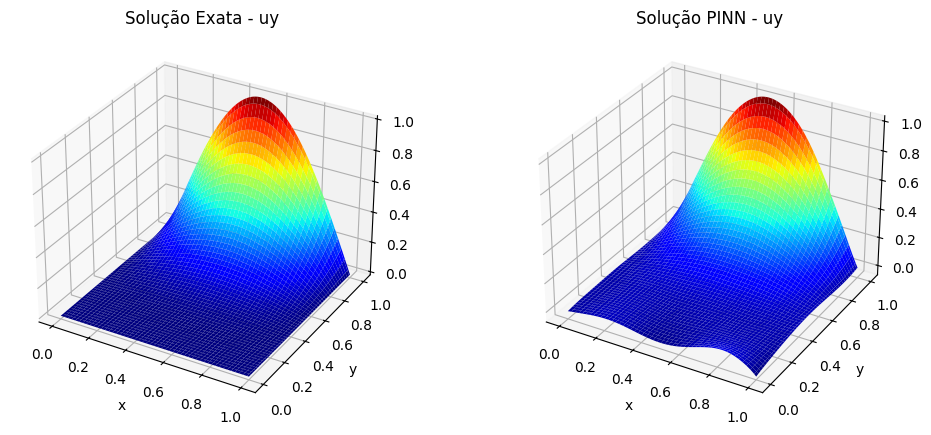

In [46]:
# Opcional: Plot 3D para uma das variáveis (exemplo com uy)
fig = plt.figure(figsize=(12, 5))

# Solução exata em 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, exact_solution[:, 1].reshape(100, 100), cmap='jet')
ax1.set_title('Solução Exata - uy')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Solução PINN em 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, predicted_solution[:, 1].reshape(100, 100), cmap='jet')
ax2.set_title('Solução PINN - uy')
ax2.set_xlabel('x')
ax2.set_ylabel('y')